# In this notebook we building the stacked ensemble using XGBoost

## Load our saved LSTM models + multivariate scaler

In [1]:
#  Imports & paths
import os, json, joblib, numpy as np, pandas as pd
from tensorflow.keras.models import load_model

# Choose which booster to use
USE_XGBOOST = True

if USE_XGBOOST:
    from xgboost import XGBRegressor
else:
    from lightgbm import LGBMRegressor

# project path
PROJECT_PATH = r"C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-"
MODEL_DIR = os.path.join(PROJECT_PATH, "models", "LSTM_Models")

# Model paths
PATH_UNIV      = os.path.join(MODEL_DIR, "univariate_lstm_model.h5")
PATH_MULTI     = os.path.join(MODEL_DIR, "multivariate_lstm_model.h5")
PATH_SEQ2SEQ   = os.path.join(MODEL_DIR, "encoder_decoder_lstm_model.h5")

# Scaler paths
PATH_SCALER_MULTI   = os.path.join(MODEL_DIR, "scaler_multivariate.pkl")
PATH_SCALER_SEQ2SEQ = os.path.join(MODEL_DIR, "scaler_seq2seq.pkl")

# Output
ENSEMBLE_DIR = os.path.join(PROJECT_PATH, "models", "Ensemble_Model")
os.makedirs(ENSEMBLE_DIR, exist_ok=True)

# Helpers (log <-> €)
def to_euro_from_log(y_log):
    return np.exp(y_log)

def ensure_log_space(arr_like):
    """
    Heuristic: if values are mostly > 30 (millions), assume they are € and log() them.
    If values ~ 10-20, assume already in log-space.
    """
    arr = np.asarray(arr_like).astype(float)
    median = np.median(arr)
    if median > 1000:  # clearly € scale
        return np.log(arr + 1e-9), True
    if median > 30:    # probably € scale in millions (raw), still log
        return np.log(arr + 1e-9), True
    # likely already log
    return arr, False

def mae(a, b):
    return float(np.mean(np.abs(a - b)))

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

print("Paths set. Booster:", "XGBoost" if USE_XGBOOST else "LightGBM")


Paths set. Booster: XGBoost


## Reload all saved splits and models

In [2]:
# Reload saved splits and models
import os
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

save_dir = os.path.join(PROJECT_PATH, "models", "LSTM_Models")


# Reload splits

# Multivariate
X_train = np.load(os.path.join(save_dir, "X_train.npy"))
X_val   = np.load(os.path.join(save_dir, "X_val.npy"))
X_test  = np.load(os.path.join(save_dir, "X_test.npy"))
y_train = np.load(os.path.join(save_dir, "y_train.npy"))
y_val   = np.load(os.path.join(save_dir, "y_val.npy"))
y_test  = np.load(os.path.join(save_dir, "y_test.npy"))

print("Reloaded multivariate splits:",
      "Train", X_train.shape, y_train.shape,
      "Val",   X_val.shape, y_val.shape,
      "Test",  X_test.shape, y_test.shape, sep="\n ")

# Univariate (if available)
X_train_uni = np.load(os.path.join(save_dir, "X_train_uni.npy"))
X_val_uni   = np.load(os.path.join(save_dir, "X_val_uni.npy"))
X_test_uni  = np.load(os.path.join(save_dir, "X_test_uni.npy"))
y_train_uni = np.load(os.path.join(save_dir, "y_train_uni.npy"))
y_val_uni   = np.load(os.path.join(save_dir, "y_val_uni.npy"))
y_test_uni  = np.load(os.path.join(save_dir, "y_test_uni.npy"))

print("\nReloaded univariate splits:",
      "Train", X_train_uni.shape, y_train_uni.shape,
      "Val",   X_val_uni.shape, y_val_uni.shape,
      "Test",  X_test_uni.shape, y_test_uni.shape, sep="\n ")

# Reload models
custom_objects = {"mse": MeanSquaredError()}

univariate_model       = load_model(os.path.join(save_dir, "univariate_lstm_model.h5"),
                                    custom_objects=custom_objects)
multivariate_model     = load_model(os.path.join(save_dir, "multivariate_lstm_model.h5"),
                                    custom_objects=custom_objects)
encoder_decoder_model  = load_model(os.path.join(save_dir, "encoder_decoder_lstm_model.h5"),
                                    custom_objects=custom_objects)

# Reload scalers
scaler_multi   = joblib.load(os.path.join(save_dir, "scaler_multivariate.pkl"))
scaler_seq2seq = joblib.load(os.path.join(save_dir, "scaler_seq2seq.pkl"))

print("\nModels and scalers loaded successfully!")

Reloaded multivariate splits:
 Train
 (200, 4, 13)
 (200,)
 Val
 (43, 4, 13)
 (43,)
 Test
 (43, 4, 13)
 (43,)

Reloaded univariate splits:
 Train
 (200, 3, 1)
 (200,)
 Val
 (43, 3, 1)
 (43,)
 Test
 (43, 3, 1)
 (43,)



Models and scalers loaded successfully!


## Generating LSTM predictions for ensemble

In [3]:
# Generate predictions from all LSTM models for ensemble

def safe_predict(model, X, squeeze=True):
    """Run model.predict safely and format output."""
    if model is None:
        return None
    pred = model.predict(X, verbose=0)
    if squeeze:
        pred = np.asarray(pred).squeeze()
    return pred

# Univariate predictions
pred_train_uni = safe_predict(univariate_model, X_train_uni)
pred_val_uni   = safe_predict(univariate_model, X_val_uni)
pred_test_uni  = safe_predict(univariate_model, X_test_uni)

# Multivariate predictions (1-step)
pred_train_multi = safe_predict(multivariate_model, X_train)
pred_val_multi   = safe_predict(multivariate_model, X_val)
pred_test_multi  = safe_predict(multivariate_model, X_test)

# Seq2Seq predictions (multi-step, we use both horizons)
def seq2seq_predict(model, X):
    if model is None: return None, None
    p = model.predict(X, verbose=0)   # (n, 2, 1)
    p = p.reshape(p.shape[0], p.shape[1])  # (n, 2)
    return p[:, 0], p[:, 1]

pred_train_h1, pred_train_h2 = seq2seq_predict(encoder_decoder_model, X_train)
pred_val_h1,   pred_val_h2   = seq2seq_predict(encoder_decoder_model, X_val)
pred_test_h1,  pred_test_h2  = seq2seq_predict(encoder_decoder_model, X_test)

print("Prediction shapes:")
print(" Univariate:", pred_train_uni.shape if pred_train_uni is not None else None)
print(" Multivariate:", pred_train_multi.shape if pred_train_multi is not None else None)
print(" Seq2Seq h1:", pred_train_h1.shape if pred_train_h1 is not None else None)
print(" Seq2Seq h2:", pred_train_h2.shape if pred_train_h2 is not None else None)


Prediction shapes:
 Univariate: (200,)
 Multivariate: (200,)
 Seq2Seq h1: (200,)
 Seq2Seq h2: (200,)


## Build meta-feature matrices for ensemble

In [5]:
# Build meta-feature matrices (stack predictions as features)

import numpy as np

def build_meta_features(pred_uni, pred_multi, pred_h1, pred_h2):
    """Combine all available predictions into a feature matrix."""
    features = []
    if pred_uni is not None:   features.append(pred_uni.reshape(-1, 1))
    if pred_multi is not None: features.append(pred_multi.reshape(-1, 1))
    if pred_h1 is not None:    features.append(pred_h1.reshape(-1, 1))
    if pred_h2 is not None:    features.append(pred_h2.reshape(-1, 1))
    return np.hstack(features)

# Train/Val/Test meta-feature matrices
X_meta_train = build_meta_features(pred_train_uni, pred_train_multi, pred_train_h1, pred_train_h2)
X_meta_val   = build_meta_features(pred_val_uni, pred_val_multi, pred_val_h1, pred_val_h2)
X_meta_test  = build_meta_features(pred_test_uni, pred_test_multi, pred_test_h1, pred_test_h2)

# Targets (1D arrays already in log-space)
y_train_meta = y_train
y_val_meta   = y_val
y_test_meta  = y_test

print("Meta-feature shapes:")
print(" Train:", X_meta_train.shape, y_train_meta.shape)
print(" Val:  ", X_meta_val.shape, y_val_meta.shape)
print(" Test: ", X_meta_test.shape, y_test_meta.shape)


Meta-feature shapes:
 Train: (200, 4) (200,)
 Val:   (43, 4) (43,)
 Test:  (43, 4) (43,)


## Train XGBoost ensemble model

In [6]:
# Train XGBoost ensemble model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define ensemble model
xgb_ensemble = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train on meta-features (without early stopping)
xgb_ensemble.fit(X_meta_train, y_train_meta)

# Evaluate
pred_val_ens  = xgb_ensemble.predict(X_meta_val)
pred_test_ens = xgb_ensemble.predict(X_meta_test)

mse_val = mean_squared_error(y_val_meta, pred_val_ens)
mae_val = mean_absolute_error(y_val_meta, pred_val_ens)

mse_test = mean_squared_error(y_test_meta, pred_test_ens)
mae_test = mean_absolute_error(y_test_meta, pred_test_ens)

print("\n--- Ensemble Performance ---")
print(f"Validation MSE: {mse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test MSE:       {mse_test:.4f}, MAE: {mae_test:.4f}")



--- Ensemble Performance ---
Validation MSE: 0.9614, MAE: 0.8241
Test MSE:       0.7116, MAE: 0.6546


## Compare LSTM vs Ensemble Predictions

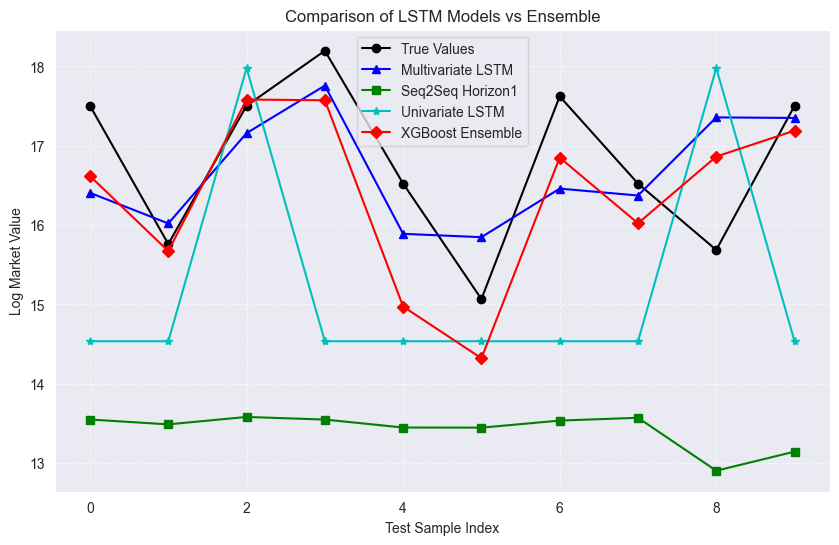

In [7]:
# Compare base models vs ensemble predictions
import matplotlib.pyplot as plt

# Take first 10 test samples for visualization
idx = range(10)

plt.figure(figsize=(10,6))
plt.plot(idx, y_test_meta[:10], "ko-", label="True Values")

plt.plot(idx, pred_test_multi[:10], "b^-", label="Multivariate LSTM")
plt.plot(idx, pred_test_h1[:10], "gs-", label="Seq2Seq Horizon1")
if pred_test_uni is not None:
    plt.plot(idx, pred_test_uni[:10], "c*-", label="Univariate LSTM")
plt.plot(idx, pred_test_ens[:10], "rD-", label="XGBoost Ensemble")

plt.xlabel("Test Sample Index")
plt.ylabel("Log Market Value")
plt.title("Comparison of LSTM Models vs Ensemble")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## Metrics table for all models vs ensemble

In [9]:
# Final Evaluation: Metrics Table
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

# Ensure test targets are in log-space (handle 1D or 2D)
if y_test.ndim == 1:
    y_test_log = np.log1p(y_test)  # already 1D
else:
    y_test_log = np.log1p(y_test[:, 0])  # first horizon only if 2D

results = {}

# Multivariate LSTM
if "pred_test_multi" in globals() and pred_test_multi is not None:
    results["Multivariate LSTM"] = {
        "MSE": mean_squared_error(y_test_log, pred_test_multi),
        "MAE": mean_absolute_error(y_test_log, pred_test_multi),
    }

# Univariate LSTM
if "pred_test_uni" in globals() and pred_test_uni is not None:
    results["Univariate LSTM"] = {
        "MSE": mean_squared_error(y_test_log, pred_test_uni),
        "MAE": mean_absolute_error(y_test_log, pred_test_uni),
    }

# Seq2Seq Horizon 1
if "pred_test_h1" in globals() and pred_test_h1 is not None:
    results["Seq2Seq Horizon1"] = {
        "MSE": mean_squared_error(y_test_log, pred_test_h1),
        "MAE": mean_absolute_error(y_test_log, pred_test_h1),
    }

# Ensemble (XGBoost)
if "pred_test_ens" in globals() and pred_test_ens is not None:
    results["XGBoost Ensemble"] = {
        "MSE": mean_squared_error(y_test_log, pred_test_ens),
        "MAE": mean_absolute_error(y_test_log, pred_test_ens),
    }

# Convert to DataFrame
metrics_df = pd.DataFrame(results).T.round(4)
print("\nFinal Model Performance (Test Set, Log-Space):")
display(metrics_df)



Final Model Performance (Test Set, Log-Space):


,MSE,MAE
Multivariate LSTM,196.9502,14.0154
Univariate LSTM,146.6593,12.0593
Seq2Seq Horizon1,102.5909,10.0637
XGBoost Ensemble,190.3365,13.7647


## Saving Ensemble model and metrics csv

In [10]:
# Save Ensemble Model + Metrics Report
import os
import joblib

ENSEMBLE_DIR = os.path.join(PROJECT_PATH, "models", "Ensemble_Model")
os.makedirs(ENSEMBLE_DIR, exist_ok=True)

# Save trained XGBoost ensemble
ensemble_path = os.path.join(ENSEMBLE_DIR, "xgb_ensemble.pkl")
joblib.dump(xgb_ensemble, ensemble_path)

# Save metrics as CSV
metrics_path = os.path.join(ENSEMBLE_DIR, "ensemble_metrics.csv")
metrics_df.to_csv(metrics_path, index=True)

print("Ensemble model and metrics saved successfully!")
print(" - Ensemble model:", ensemble_path)
print(" - Metrics report:", metrics_path)


Ensemble model and metrics saved successfully!
 - Ensemble model: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\models\Ensemble_Model\xgb_ensemble.pkl
 - Metrics report: C:\Users\asing\PycharmProjects\-Dynamic-Player-Transfer-Value-Prediction-using-AI-and-Multi-source-Data-\models\Ensemble_Model\ensemble_metrics.csv


## Sanity check

In [11]:
# Reload Ensemble Model and Test
import joblib
import numpy as np

# Reload model
ensemble_path = os.path.join(ENSEMBLE_DIR, "xgb_ensemble.pkl")
xgb_loaded = joblib.load(ensemble_path)
print("Ensemble model reloaded successfully!")

# Sanity check: predict on a small batch from test meta-features
sample_idx = np.random.choice(len(X_meta_test), size=3, replace=False)
X_sample = X_meta_test[sample_idx]
y_sample = y_test_meta[sample_idx]

pred_sample = xgb_loaded.predict(X_sample)

print("\nSanity Check")
for i in range(len(sample_idx)):
    print(f"True={y_sample[i]:.2f}, Pred={pred_sample[i]:.2f}")


Ensemble model reloaded successfully!

Sanity Check
True=16.81, Pred=16.41
True=17.45, Pred=17.96
True=17.50, Pred=16.62
